In [1]:
import sys
sys.path.insert(1, '../../unseen')

import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import fileio

## Forecast climatology

In [180]:
cafe_files = ['/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19930501/atmos_isobaric_daily.zarr.zip',
              '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19931101/atmos_isobaric_daily.zarr.zip',
              '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19940501/atmos_isobaric_daily.zarr.zip',
              '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19941101/atmos_isobaric_daily.zarr.zip']

In [182]:
ds_forecast = fileio.open_mfforecast(cafe_files,
                                     variables=['tasmax'],
                                     spatial_coords=[47.45, 237.69],
                                     units={'tasmax': 'C'},
                                     metadata_file='../../config/dataset_cafe_daily.yml',
                                     input_freq='D',
                                     no_leap_days=True,
                                    )

In [183]:
ds_forecast = ds_forecast.compute()

In [184]:
ds_forecast['lead_time'].size

3650

In [187]:
ds_forecast['time'].dt.dayofyear[974:1341, 0]

<xarray.DataArray 'dayofyear' (lead_time: 367)>
array([365,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366,   1])
Coordinates:
  * lead_time  (lead_time) int64 974 975 976 977 978 ... 1337 1338 1339 1340
    init_date  object 1993-05-01 00:00:00
    time       (lead_time) object 1995-12-31 12:00:00 ... 1997-01-01 12:00:00

I used `no_leap_years=True` when reading the data but some years still go to 366 even though they are only 365 days long because day 60 is simply missing in leap years.

In [188]:
clim_forecast = ds_forecast.groupby('init_date.month').mean(['ensemble', 'init_date'])
#TODO: Add time period selection to forecast climatology calculation

In [189]:
clim_forecast

<xarray.Dataset>
Dimensions:    (lead_time: 3650, month: 2)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 ... 3644 3645 3646 3647 3648 3649
  * month      (month) int64 5 11
Data variables:
    tasmax     (month, lead_time) float32 12.94 12.13 12.12 ... 6.822 6.693

In [190]:
obs_file = '/g/data/xv83/dbi599/seatac/data/tasmax_GHCNv2_SeaTac_daily_1948-2021.nc'

In [191]:
ds_obs = fileio.open_file(obs_file,
                          variables=['tasmax'],
                          units={'tasmax': 'C'},
                          metadata_file='../../config/dataset_knmi_daily.yml',
                          input_freq='D',
                         )

In [192]:
ds_obs = ds_obs.compute()

In [202]:
def daily_climatology(ds):
    """Calculate the daily climatology"""
    
    clim = ds.groupby('time.dayofyear').mean('time')
    
    max_day = int(clim['dayofyear'].values.max())
    assert max_day in [365, 366]
    if max_day == 366:
        noleap_idx = np.delete(np.arange(0, 366), 59)
        clim = clim.isel({'dayofyear': noleap_idx})
        clim = clim.assign_coords({'dayofyear': np.arange(1, 366)})
    
    return clim

#TODO: Add time period selection

In [194]:
clim_obs = daily_climatology(ds_obs)

In [195]:
clim_obs

<xarray.Dataset>
Dimensions:    (dayofyear: 365)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    tasmax     (dayofyear) float32 6.943 6.622 6.588 6.699 ... 6.704 6.834 5.989

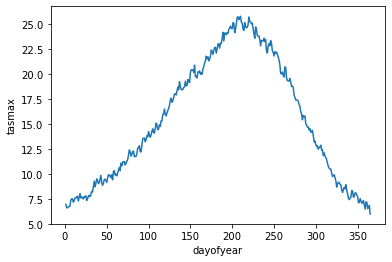

In [196]:
clim_obs['tasmax'].plot()
plt.show()

In [203]:
def roll_daily_climatology(clim, forecast_ds):
    """Roll observed daily climatology to match forecast initial dates"""
    
    n_lead_times = forecast_ds['lead_time'].size
    n_cycles = n_lead_times / 365
    assert n_cycles.is_integer()
    
    init_months = np.unique(forecast_ds['init_date'].dt.month.values)
    init_daysofyear = forecast_ds['init_date'].dt.dayofyear.values[0:len(init_months)]
    rolled_clim_list = []
    for month, dayofyear in zip(init_months, init_daysofyear):
        roll_number = 365 - (dayofyear - 1)
        clim_shifted = clim.roll(dayofyear=roll_number, roll_coords=True)
        first_day = int(clim_shifted['dayofyear'][0])
        assert first_day == dayofyear
        clim_shifted = clim_shifted.rename({'dayofyear': 'lead_time'})
        clim_shifted = xr.concat([clim_shifted]*int(n_cycles), dim='lead_time')
        clim_shifted = clim_shifted.assign_coords({'lead_time': ds['lead_time']})
        clim_shifted = clim_shifted.assign_coords({'month': month})
        rolled_clim_list.append(clim_shifted)
    rolled_clim = xr.concat(rolled_clim_list, dim='month')
        
    return rolled_clim

In [204]:
clim_obs_rolled = roll_daily_climatology(clim_obs, ds)

In [205]:
clim_obs_rolled

<xarray.Dataset>
Dimensions:    (lead_time: 3650, month: 2)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 ... 3644 3645 3646 3647 3648 3649
  * month      (month) int64 5 11
Data variables:
    tasmax     (month, lead_time) float32 15.81 16.08 16.36 ... 12.47 12.65

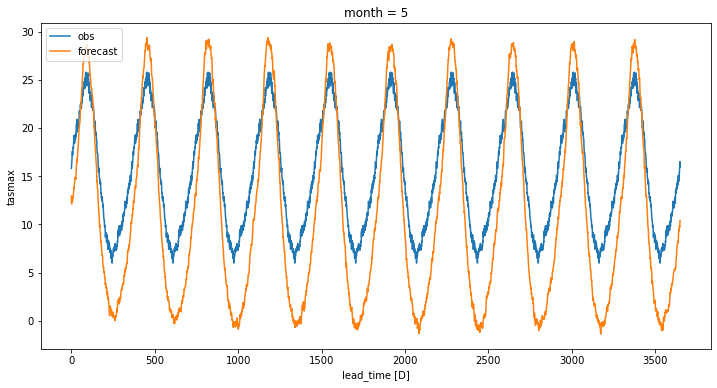

In [206]:
plt.figure(figsize=[12,6])
clim_obs_rolled['tasmax'].isel({'month': 0}).plot(label='obs')
clim_forecast['tasmax'].isel({'month': 0}).plot(label='forecast')
plt.legend()
plt.show()

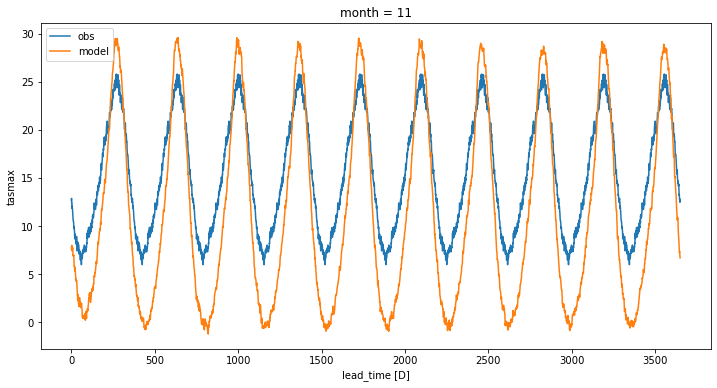

In [207]:
plt.figure(figsize=[12,6])
clim_obs_rolled['tasmax'].isel({'month': 1}).plot(label='obs')
clim_forecast['tasmax'].isel({'month': 1}).plot(label='model')
plt.legend()
plt.show()

In [212]:
bias = clim_forecast['tasmax'] - clim_obs_rolled['tasmax']

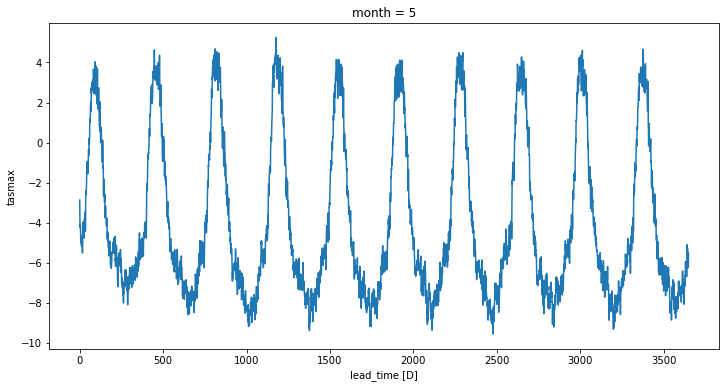

In [218]:
plt.figure(figsize=[12,6])
bias.isel({'month': 0}).plot()
plt.show()

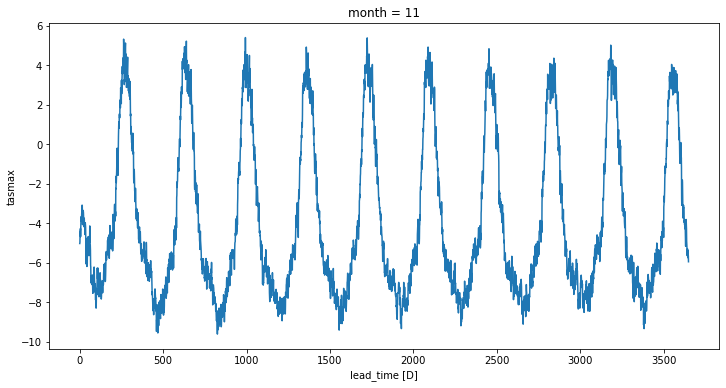

In [219]:
plt.figure(figsize=[12,6])
bias.isel({'month': 1}).plot()
plt.show()

The seasonal cycle of tmax is greater in the model so (relative to obs) the bias is positive in the summer and negative in winter.